<h1>Introduction</h1>





<h3>Simulation and parameters</h3>

Similar the introductory experiment (see DEMO or Readme). We simulate three correlated brownian motions to represent the price changes.
The client in this experiment will randomly trade with no thoughts on market, current position nor past actions
Our simulation will have 2000 time steps, where the first 1000 will be considered a grace period. No trades will be executed during that time. This represents the historical data available at the start of the experiment. Without any grace period, any statistical estimate in the early parts of the experiment will be very inaccurate.

BLAH BLAH BLAH

<h3>Naive Back-to-Back hedging</h3>
The simplest way to reduce any risk is to fully hedge any position as soon as possible. We refer to this as back-to-back. A Back-to-back hedger will immediately pass on any trade against it onto the interbank market. (We use a "World book" to represent an interbank market that will serve as a risk sink). While this approach has very low risk, it is only really profitable if the interbank market offers tighter/better prices than the prices our market maker show the client.
In our experiment, we do not allow our market maker to act after the client has traded. This means that the maker has to endure a single time tick before the maker can hedge. This induces a tiny "timing" risk to our market maker.

If assets are correlated, this approach is increasingly ineffective as highly correlated positions might cancel out risk.
Below we plot the perceived risk of a given position $w$ and covariance matrix $\Sigma$ of two assets with correlation $\rho$:

$$ w^T \Sigma w $$

where $w = (1 \ , \ -1)$.

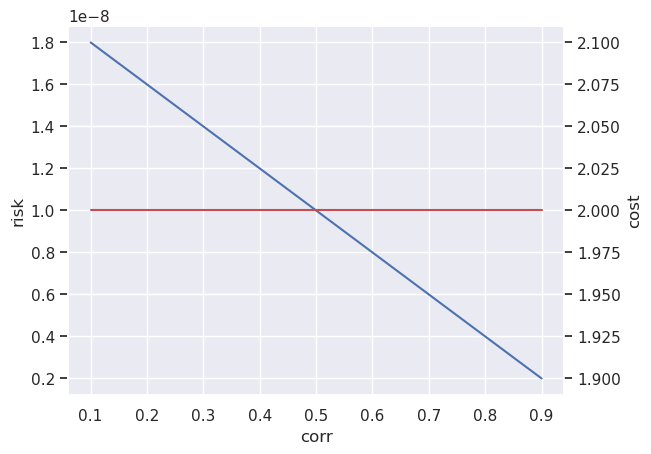

In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

dt = 0.001
vol = 0.1

w = np.array([1, -1]) #position

rhos = np.arange(0.1, 0.95, 0.05) # correlation

def back_to_back(rho):
    cov = np.array([[1, rho],
                    [rho, 1]]) * (vol*dt)**2    
    return {'corr': rho, 'cost': np.sum(np.abs(w)), 'risk': np.matmul(w.T, np.matmul(cov, w))} # wT Sigma w

df = pd.DataFrame([back_to_back(rho) for rho in rhos])

sns.lineplot(data=df, x='corr', y='risk' )
ax2 = plt.twinx()
sns.lineplot(data=df,  x='corr', y='cost', color="r", ax=ax2)
ax2.grid(False)

<h3>Principal Component Analysis</h3>
The assets in our experiment are all correlated, which means that 

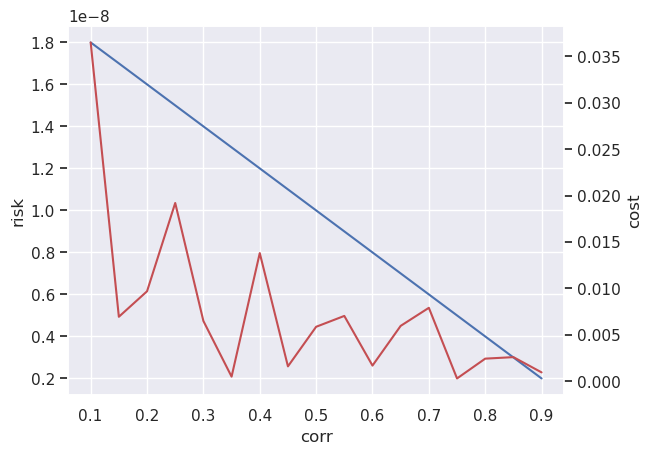

In [204]:
from generator import Generator
from sklearn.decomposition import PCA

fx_crosses = ['EURUSD', 'EURGBP']
start_rates = [1.11, 0.895]
w = pd.DataFrame([[1, -1]], columns=fx_crosses)

num_steps = 100000
generator = Generator(fx_crosses)

def PCA_back_to_back(rho):
    # Correlation matrix
    correlation_matrix = np.array([[1.0, rho],
                                   [rho, 1.0]])

    df = generator.simulate_rates(start_rates, vol, dt, num_steps, correlation_matrix).diff().iloc[1:]

    cov = correlation_matrix * (vol*dt)**2

    # setup pca
    pca = PCA(n_components=1)
    # fit the PCA
    pca.fit(df)
    # see how well it explains
    u = pca.inverse_transform(pca.transform(w))[0]

    h = w.values[0] - u # final position
    
    return {'corr': rho, 'cost': np.sum(np.abs(u)), 'risk': np.matmul(h.T, np.matmul(cov, h)), 'explained_var': pca.explained_variance_ratio_[0]}


pca_df = pd.DataFrame([PCA_back_to_back(rho) for rho in rhos])

sns.lineplot(data=pca_df, x='corr', y='risk' )
ax2 = plt.twinx()
sns.lineplot(data=pca_df,  x='corr', y='cost', color="r", ax=ax2)
ax2.grid(False)

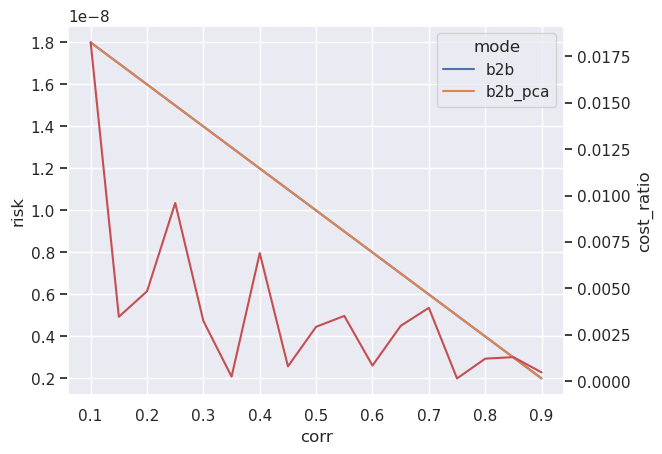

In [243]:
a = pca_df.merge(df, on='corr', suffixes=('_pca',''), how='left')
a['risk_diff'] = a['risk'] - a['risk_pca']
a['cost_ratio'] = a['cost_pca']/a['cost']


pltdata = a[['corr', 'risk', 'risk_pca']].set_index('corr')
pltdata.columns = ['b2b', 'b2b_pca']

pltdata = pltdata.melt(ignore_index=False, var_name='mode', value_name='risk').reset_index()
pltdata

#sns.lineplot(data=a, x='corr', y='risk_diff')
sns.lineplot(data=pltdata, x='corr', y='risk', hue='mode')
ax2 = plt.twinx()
sns.lineplot(data=a,  x='corr', y='cost_ratio', color="r", ax=ax2)
ax2.grid(False)

# So the PCA will normalize distributions hence why our hedge transform-inverse transform is small?
# We probably have to find U such that U.T \sigma_pca U = 0? Which means the U that minimizes the risk from a pca perspective.
# Then we see if that ssmaller or larger than w hedge cost wise.
# and to what extend does it actually hedge ...

A lot of this does not make a lot of sense. When doing PCA in and out, we get a tiny hedge amount back. Okay. This means we barely hedge anything, so obviously our risk is similar to naive case.
The cost is tiny, but we are also not really hedging anything.
We might have to do risk / cost to see how much do we pay per risk unit. This will be VERY high in naive case when high correlation. What will this be for PCA? Let's find out

melt it such that we can show pca and non pca

<h3> Conclusion </h3>
